In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2017-01-02',
    'to': '2018-10-01'
})

loading data 422765343d4f6e214c41091598dd9cb9 from cache
preparing model data
training knn_10
mea: 4.045300439974859
training knn_100
mea: 4.042992489000628
training mlp_10
mea: 3.8784596458314713
training mlp_100
mea: 4.01874765566886
training gbr_10
mea: 4.073984777098436
training gbr_100
mea: 4.509486318844861
training rf_10
mea: 4.913756372527012
training rf_100
mea: 4.905736137798929
training knn_10
mea: 3.9769033626649906
training knn_100
mea: 3.987407573852923
training mlp_10
mea: 3.9301924342372474
training mlp_100
mea: 3.908729383142868
training gbr_10
mea: 3.985462590336489
training gbr_100
mea: 4.298977301116855
training rf_10
mea: 4.779692178100027
training rf_100
mea: 4.715166199081142


In [4]:
program.dataset.save()
print(program.dataset.hash)
program.model.save()
print(program.model.hash)

422765343d4f6e214c41091598dd9cb9
8948b3ec9f8d1a9f09e4610a770ae0f9


In [5]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

11106 races from 2017-01-02 11:40:00 to 2018-06-21 18:35:00


In [6]:
from cataclop.ml import exploration

program.df.isnull().sum()

id                              0
age                             0
earnings                        0
final_odds                   1876
final_odds_ref                  0
handicap_distance               0
handicap_weight                 0
herder_id                   42976
horse_id                        0
imported_at_player              0
is_first_timer                  0
is_racing                       0
jockey_id                       0
music                           0
num                             0
owner_id                        1
placed_2_count                  0
placed_3_count                  0
placed_count                    0
placed_dividend                 0
placed_earnings                 0
position                    15311
post_position                   0
prev_year_earnings              0
race_count                      0
race_id                         0
time                        98057
trainer_id                      0
victory_count                   0
victory_earnin

In [7]:
import pandas as pd
from cataclop.ml import preprocessing

for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


gbr_10
odds_9                                          0.214322
hist_1_pos                                      0.137935
odds_8                                          0.134139
victory_earnings_r                              0.103188
odds_4                                          0.054357
placed_3_count                                  0.046775
declared_player_count                           0.033230
odds_7                                          0.032284
hist_2_pos                                      0.030501
odds_0                                          0.029935
handicap_distance_std                           0.021903
placed_3_count_mean                             0.019947
handicap_weight_r                               0.019269
victory_count_r                                 0.017351
odds_2                                          0.013623
placed_3_count_amin                             0.012335
odds_1                                          0.011545
prize                   

In [8]:
program.bet(N=1, max_odds=20)
bets = program.bets
bets['profit'].describe()

count    53901.000000
mean        -0.206063
std          3.360021
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         77.200000
Name: profit, dtype: float64

In [9]:
bets = bets.reset_index(drop=True)

---
COURSE_A_CONDITIONS	-555.20	+2308.00	+2308.00
---
pred_gbr_10_1: 	 -386.20 	 +1205 	 -0.32
pred_gbr_100_1: 	 -154.00 	 +1088 	 -0.14


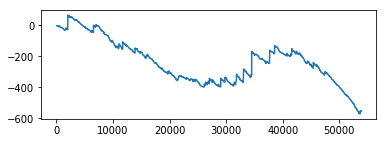

---
HANDICAP	-291.80	+1421.00	+1421.00
---
pred_gbr_10_1: 	 -129.30 	 +721 	 -0.18
pred_gbr_100_1: 	 -161.50 	 +699 	 -0.23


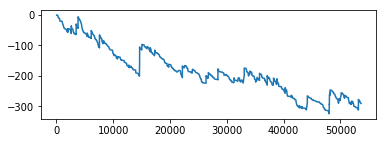

---
AUTOSTART	-351.70	+1004.00	+1004.00
---
pred_gbr_10_1: 	 -191.20 	 +505 	 -0.38
pred_gbr_100_1: 	 -153.50 	 +492 	 -0.31


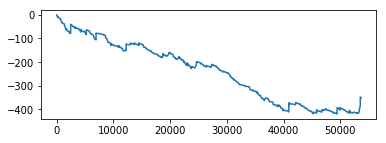

---
HANDICAP_DIVISE	+339.80	+654.00	+654.00
---
pred_gbr_10_1: 	 +217.60 	 +333 	 +0.65
pred_gbr_100_1: 	 +126.20 	 +317 	 +0.40


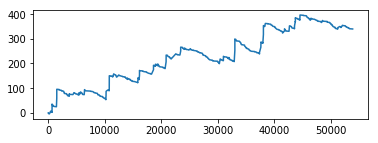

---
A_RECLAMER	-97.50	+485.00	+485.00
---
pred_gbr_10_1: 	 -17.90 	 +259 	 -0.07
pred_gbr_100_1: 	 -79.60 	 +226 	 -0.35


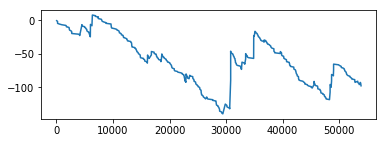

---
INTERNATIONALE_AUTOSTART	-17.30	+253.00	+253.00
---
pred_gbr_10_1: 	 -29.50 	 +130 	 -0.23
pred_gbr_100_1: 	 +12.20 	 +123 	 +0.10


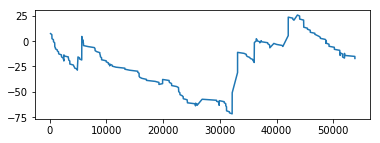

---
HANDICAP_CATEGORIE_DIVISE	-61.80	+248.00	+248.00
---
pred_gbr_100_1: 	 -43.00 	 +123 	 -0.35
pred_gbr_10_1: 	 -32.30 	 +122 	 -0.26


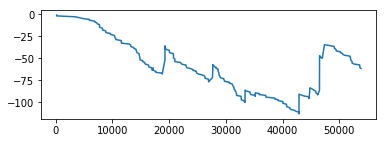

---
HANDICAP_DE_CATEGORIE	+19.10	+121.00	+121.00
---
pred_gbr_10_1: 	 +5.40 	 +62 	 +0.09
pred_gbr_100_1: 	 +13.70 	 +59 	 +0.23


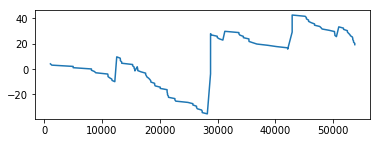

---
NATIONALE_AUTOSTART	-6.50	+115.00	+115.00
---
pred_gbr_100_1: 	 -21.00 	 +62 	 -0.34
pred_gbr_10_1: 	 +14.50 	 +53 	 +0.27


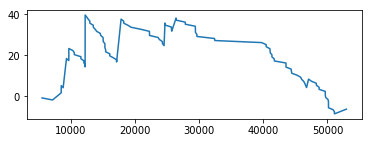

---
GROUPE_III	-61.50	+101.00	+101.00
---
pred_gbr_100_1: 	 -28.30 	 +51 	 -0.55
pred_gbr_10_1: 	 -33.20 	 +50 	 -0.66


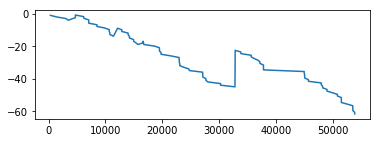

---
GROUPE_II	-13.70	+100.00	+100.00
---
pred_gbr_10_1: 	 -13.50 	 +58 	 -0.23
pred_gbr_100_1: 	 -0.20 	 +42 	 -0.00


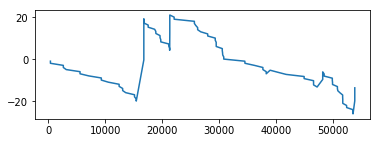

---
GROUPE_I	-24.30	+90.00	+90.00
---
pred_gbr_10_1: 	 -11.20 	 +45 	 -0.25
pred_gbr_100_1: 	 -12.10 	 +44 	 -0.27


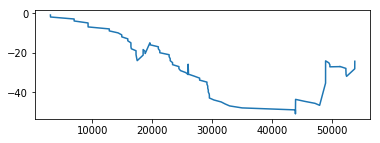

---
COURSE_A_CONDITION_QUALIF_HP	+125.40	+70.00	+70.00
---
pred_gbr_10_1: 	 +78.40 	 +38 	 +2.06
pred_gbr_100_1: 	 +47.00 	 +32 	 +1.47


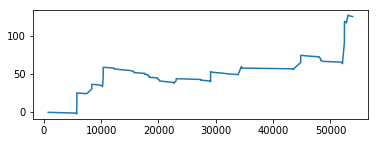

---
EUROPEENNE_AUTOSTART	+16.10	+57.00	+57.00
---
pred_gbr_10_1: 	 -1.50 	 +28 	 -0.05
pred_gbr_100_1: 	 +3.10 	 +28 	 +0.11


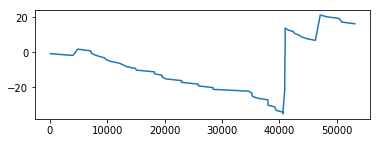

---
AMATEURS_AUTOSTART	-9.00	+56.00	+56.00
---
pred_gbr_100_1: 	 +3.10 	 +31 	 +0.10
pred_gbr_10_1: 	 -12.10 	 +25 	 -0.48


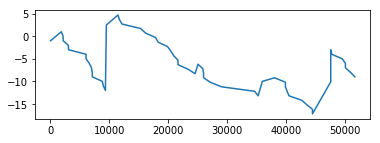

---
INCONNU	+54.50	+47.00	+47.00
---
pred_gbr_10_1: 	 +34.00 	 +25 	 +1.36
pred_gbr_100_1: 	 +20.50 	 +22 	 +0.93


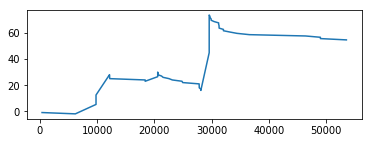

---
APPRENTIS_LADS_JOCKEYS_AUTOSTART	+11.30	+35.00	+35.00
---
pred_gbr_100_1: 	 +22.20 	 +19 	 +1.17
pred_gbr_10_1: 	 -10.90 	 +16 	 -0.68


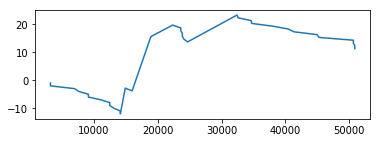

---
AMATEURS_INTERNATIONALE_AUTOSTART	-8.20	+12.00	+12.00
---
pred_gbr_100_1: 	 -5.10 	 +7 	 -0.73
pred_gbr_10_1: 	 -3.10 	 +5 	 -0.62


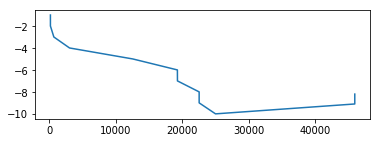

---
A_RECLAMER_AUTOSTART	+31.60	+11.00	+11.00
---
pred_gbr_100_1: 	 +13.30 	 +8 	 +1.66
pred_gbr_10_1: 	 +19.30 	 +2 	 +9.65


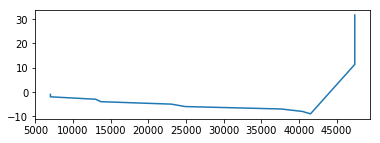

---
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART	-10.00	+10.00	+10.00
---
pred_gbr_100_1: 	 -7.00 	 +7 	 -1.00
pred_gbr_10_1: 	 -3.00 	 +3 	 -1.00


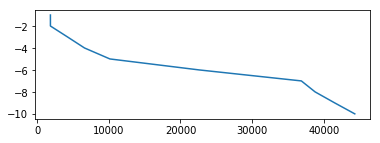

---
HANDICAP_A_RECLAMER	-5.00	+5.00	+5.00
---
pred_gbr_100_1: 	 -3.00 	 +3 	 -1.00
pred_gbr_10_1: 	 -2.00 	 +2 	 -1.00


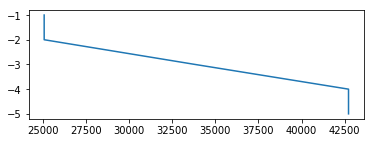

---
QUALIFICATION_ACCAF	-3.00	+3.00	+3.00
---
pred_gbr_10_1: 	 -2.00 	 +2 	 -1.00
pred_gbr_100_1: 	 -1.00 	 +1 	 -1.00


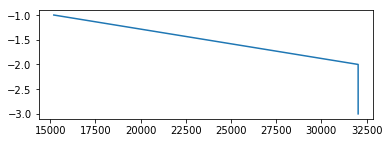

---
FINALE_REGIONALE_ACCAF	-2.00	+2.00	+2.00
---
pred_gbr_100_1: 	 -1.00 	 +1 	 -1.00
pred_gbr_10_1: 	 -1.00 	 +1 	 -1.00


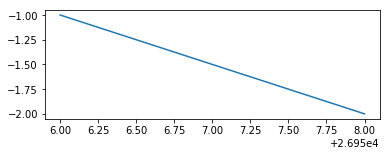

---
COURSE_INTERNATIONALE	-1.00	+1.00	+1.00
---
pred_gbr_10_1: 	 -1.00 	 +1 	 -1.00


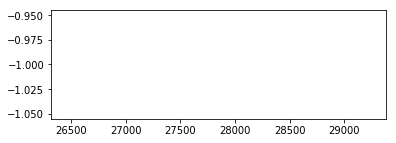

In [18]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

bb = bets[(bets['target'].str.contains('^pred_gbr')) ].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets[(bets['target'].str.contains('^pred_mlp')) & (bets['pred_stacked_1']>1)].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets.groupby('id').filter(lambda r: (r['target'] == 'pred_mlp_1').sum() == 0 and (r['target'] == 'pred_knn_10_1').sum() == 1  )

def f(r):
    n1 = r[(r['target'] == 'pred_mlp_100_1')]['num']
    n2 = r[(r['target'] == 'pred_rf_100_1')]['num']
    
    if not len(n1) and len(n2):
        return True
    if not len(n2) and len(n1):
        return True
    
    if n1.max() != n2.max():
        return True
    
    return False

#bb = bets.groupby('id').filter(f)

f = 'sub_category'

for s in bb[f].value_counts().index:
    x = bb[bb[f] == s].copy()
    print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))
    for t in x['target'].value_counts().index:
        bbb = x[(x['target'] == t) & (x['odds_ref'] < 20)].copy()
        print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )
        
    x['stash'] = x['profit'].cumsum()

    fig, axs = plt.subplots(1,1)
    x['stash'].plot(figsize=(6, 2))
    plt.show()

In [11]:
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

groups = bets['id'].values
group_kfold = GroupKFold(n_splits=2)
splits = list(group_kfold.split(bets.values, bets.profit.values, groups))

targets = ['pred_{}_1'.format(model['name']) for model in program.model.models]

features = []

for target in targets:
    bets[target] = (bets['target'] == target).astype(np.float)
    bets['pred_{}'.format(target)] = 0
    features.append(target)
    features.append('pred_{}'.format(target))
    
cats = program.df['sub_category'].value_counts()[0:5].index

for cat in cats:
    bets['cat_{}'.format(cat)] = (bets['sub_category'] == cat).astype(np.float)
    features.append('cat_{}'.format(cat))

bets['pred_stacked_1'] = 0.

races = bets.groupby('id')

for (id, race) in races:
    for target in targets:
        bets.loc[race.index, 'pred_{}'.format(target)] = race[ race['target'] == target ]['pred'].max()

features += ['pred']

bets.fillna(0, inplace=True)

for train_index, test_index in splits:
    
    X_train = bets[features].iloc[train_index].copy()
    y_train = bets['profit'].iloc[train_index]
    
    #print(X_train.describe())
    
    X_test = bets[features].iloc[test_index].copy()
    y_test = bets['profit'].iloc[test_index]
    
    idx = bets.iloc[test_index].index
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=1234)
    estimator.fit(X_train.values, y_train.values)
    
    p = estimator.predict(X_test.values)
    bets.loc[idx, 'pred_stacked_1'] = p




In [12]:
import pandas as pd
from cataclop.ml import preprocessing

fi = pd.Series(estimator.feature_importances_, index=features)
print(fi.sort_values(ascending=False)[0:100])
print("---\n")


pred                       0.200677
pred_pred_rf_10_1          0.095688
pred_pred_rf_100_1         0.092953
pred_pred_knn_10_1         0.085309
pred_pred_gbr_100_1        0.078924
pred_pred_knn_100_1        0.077723
pred_pred_gbr_10_1         0.068223
pred_pred_mlp_100_1        0.051806
pred_pred_mlp_10_1         0.034834
pred_knn_10_1              0.030589
pred_gbr_100_1             0.026908
pred_rf_10_1               0.024637
pred_knn_100_1             0.024353
pred_gbr_10_1              0.023389
cat_HANDICAP_DIVISE        0.016565
pred_rf_100_1              0.015602
pred_mlp_100_1             0.010925
pred_mlp_10_1              0.010490
cat_COURSE_A_CONDITIONS    0.009892
cat_A_RECLAMER             0.009493
cat_AUTOSTART              0.005533
cat_HANDICAP               0.005488
dtype: float64
---



In [13]:
bets[bets['pred_stacked_1'] < 1]['profit'].describe()

count    48799.000000
mean        -0.224650
std          3.234828
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         77.200000
Name: profit, dtype: float64

In [14]:
bets[bets['profit'] < 1]['pred_stacked_1'].describe()

count    49000.000000
mean        -0.019183
std          0.957023
min         -1.000000
25%         -0.589000
50%         -0.235000
75%          0.276000
max         43.221000
Name: pred_stacked_1, dtype: float64

In [15]:
bets[features][0:10]

,pred_knn_10_1,pred_pred_knn_10_1,pred_knn_100_1,pred_pred_knn_100_1,pred_mlp_10_1,pred_pred_mlp_10_1,pred_mlp_100_1,pred_pred_mlp_100_1,pred_gbr_10_1,pred_pred_gbr_10_1,pred_gbr_100_1,pred_pred_gbr_100_1,pred_rf_10_1,pred_pred_rf_10_1,pred_rf_100_1,pred_pred_rf_100_1,cat_COURSE_A_CONDITIONS,cat_AUTOSTART,cat_HANDICAP,cat_HANDICAP_DIVISE,cat_A_RECLAMER,pred
0,0.0,1.98,0.0,1.800,0.0,2.805877,1.0,2.137442,0.0,3.213897,0.0,0.000000,0.0,2.90,0.0,2.280,0.0,0.0,0.0,0.0,1.0,2.137442
1,0.0,3.33,1.0,2.702,0.0,4.114505,0.0,3.023920,0.0,0.000000,0.0,0.000000,0.0,5.75,0.0,0.000,0.0,1.0,0.0,0.0,0.0,2.702000
2,1.0,3.33,0.0,2.702,0.0,4.114505,0.0,3.023920,0.0,0.000000,0.0,0.000000,0.0,5.75,0.0,0.000,0.0,1.0,0.0,0.0,0.0,3.330000
3,0.0,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,5.148131,1.0,6.562568,0.0,0.00,0.0,0.000,0.0,1.0,0.0,0.0,0.0,6.562568
4,0.0,0.00,0.0,0.000,0.0,0.000000,0.0,0.000000,1.0,5.148131,0.0,6.562568,0.0,0.00,0.0,0.000,0.0,1.0,0.0,0.0,0.0,5.148131
5,0.0,0.00,0.0,5.773,0.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,1.0,8.396,0.0,1.0,0.0,0.0,0.0,8.396000
6,0.0,0.00,0.0,5.773,0.0,3.892718,1.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,4.051029
7,0.0,0.00,0.0,5.773,1.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,3.892718
8,0.0,0.00,1.0,5.773,0.0,3.892718,0.0,4.051029,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,8.396,0.0,1.0,0.0,0.0,0.0,5.773000
9,0.0,11.28,0.0,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.0,7.72,0.0,0.000,0.0,1.0,0.0,0.0,0.0,7.720000
